In [1]:
from pathlib import Path
from timeit import default_timer as timer
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
from torchinfo import summary
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

d:\anaconda3\envs\butterfly\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setting up the hyperparameters
IMAGE_SIZE = 224 # 224 refers to 224 height X 224 width
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 5

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

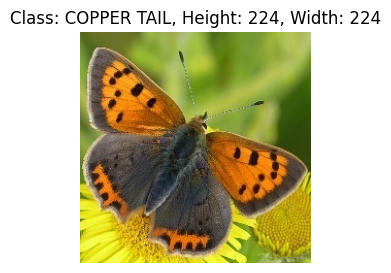

In [4]:
IMAGE_PATH = '../artifacts/data_preparation/train'
RANDOM_IMAGE_PATH = []

# Checking how many images we have in each food class
dataset_folder = os.listdir(IMAGE_PATH)

# Selecting any random image path
random_image_section = random.choice(dataset_folder)
random_image = os.path.join(IMAGE_PATH, random_image_section, 
                            random.choice(os.listdir(os.path.join(IMAGE_PATH, random_image_section))))

image = Image.open(Path(random_image))

# Display the image
plt.figure(figsize=(3, 3))
plt.title(f'Class: {random_image_section}, Height: {image.height}, Width: {image.width}')
plt.imshow(image)
plt.axis('off')  # Optional: Turn off axis labels if you prefer
plt.show()

In [5]:
# Function to transform the image and plot it
def transformed_image(image_path, transform, sample_size, random_state=42):
  # Setup seed
  torch.manual_seed(random_state)

  food_images = os.listdir(image_path)

  # Select random sample of images
  sample_image = random.sample(food_images, k=sample_size)

  for image in sample_image:
    with Image.open(os.path.join(image_path, image)) as f:
      plt.figure(figsize=(10, 8))
      fig, ax = plt.subplots(1, 2)

      # Visualize the original image
      ax[0].imshow(f)
      ax[0].set_title(f"Original size: {f.size}")
      ax[0].axis("off")

      # Visualize the transformed image
      # Transform the image and change the shape from (C, H, W) -> (H, W, C) using permute
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed size:\n {transformed_image.shape}")
      ax[1].axis("off")

    plt.suptitle(f"Class: {image_path.split('/')[-1]}")
    plt.show()

In [6]:
transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x800 with 0 Axes>

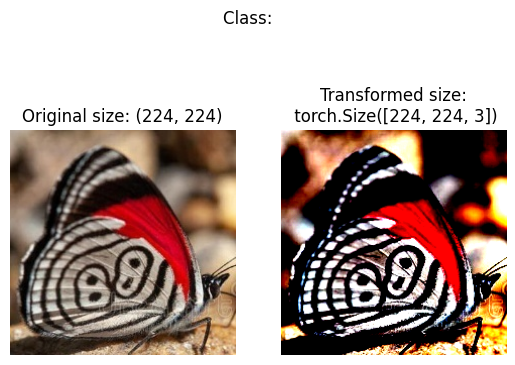

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x800 with 0 Axes>

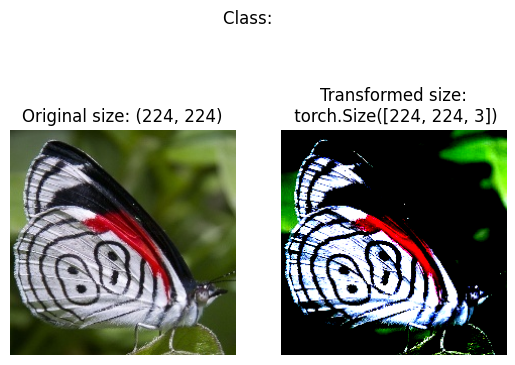

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1000x800 with 0 Axes>

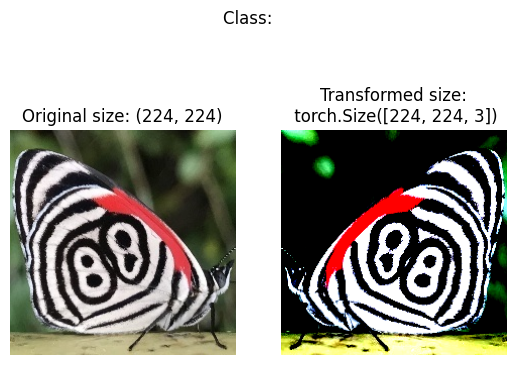

In [7]:
TRAIN_DATASET_PATH = '../artifacts/data_preparation/train/AN 88/'
transformed_image(TRAIN_DATASET_PATH, transform=transform, sample_size=3)

In [8]:
def create_data_loader(train_data_path: Path, 
                       validation_data_path: Path, 
                       transform: transforms.Compose, 
                       batch_size: int, 
                       num_workers: int) -> tuple:
    '''
    Create data loaders for training and validation datasets.

    Parameters:
        train_data_path (Path): Path to the training dataset.
        validation_data_path (Path): Path to the validation dataset.
        transform (transforms.Compose): Data transformation to be applied on the images.

    Returns:
        tuple: A tuple containing training DataLoader, validation DataLoader, and list of class names.
    '''
    # Creating ImageFolder datasets for training and validation
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform, target_transform=None)
    validation_dataset = datasets.ImageFolder(root=validation_data_path, transform=transform)

    # Creating DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # Extracting class names from the training dataset
    class_names = train_dataset.classes

    return train_dataloader, validation_dataloader, class_names

In [9]:
# Converting to train and validation to data loaders
train_image_dir = Path('../artifacts/data_preparation/train')
validation_image_dir = Path('../artifacts/data_preparation/validation')

train_dataloader, validation_dataloader, class_names = create_data_loader(train_data_path=train_image_dir, 
                                                                          validation_data_path=validation_image_dir, 
                                                                          transform=transform, 
                                                                          batch_size=BATCH_SIZE,
                                                                          num_workers=NUM_WORKERS)

In [14]:
image, label = next(iter(train_dataloader))
image.shape, len(label)

(torch.Size([32, 3, 224, 224]), 32)

In [15]:
# Setup the 3 different model with pretrained weights and send it to the target device
model_vgg16_weights = models.VGG16_Weights.DEFAULT
model_vgg16 = models.vgg16(weights=model_vgg16_weights).to(device)

model_resnet50_weights = models.ResNet50_Weights.DEFAULT
model_resnet50 = models.resnet50(weights=model_resnet50_weights).to(device)

model_efficientnetB0_weights = models.EfficientNet_B0_Weights.DEFAULT
model_efficientnetB0 = torchvision.models.efficientnet_b0(weights=model_efficientnetB0_weights).to(device)

In [16]:
# Print a summary for vgg16 using torchinfo
summary(model=model_vgg16,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   True
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   1,792                True
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   36,928               True
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  73,856               True
│    └─ReLU (6)     

In [17]:
# Print a summary for Resnet50 using torchinfo
summary(model=model_resnet50,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [18]:
# Print a summary for EfficientNet_B0 using torchinfo
summary(model=model_efficientnetB0,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [19]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# Freezing for model vgg16
for param in model_vgg16.features.parameters():
    param.requires_grad = False

# Freezing for model resnet50
for param in model_resnet50.parameters():
    param.requires_grad = False

# Freezing for model EfficientNet_B0
for param in model_efficientnetB0.features.parameters():
    param.requires_grad = False

In [20]:
# Changing the last layer of the neural network so that we train the model for our dataset problem
# Actual model was trained on 1000 different classes, but our problem is to classify 75 different classes of butterfly

# Changing the layer of vgg16 model
model_vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=len(class_names)).to(device)

# Changing the layer of resnet50 model
model_resnet50.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)

# Changing the layer of EfficientNet_B0 model
model_efficientnetB0.classifier[1] = nn.Linear(in_features=1280, out_features=len(class_names)).to(device)

In [21]:
# Print a summary for vgg16 after changing the layers
summary(model=model_vgg16,
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 75]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (

In [22]:
# Print a summary for Resnet50 after changing the layer
summary(model=model_resnet50,
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 75]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [23]:
# Print a summary for EfficientNet_B0 after changing the layer
summary(model=model_efficientnetB0,
        input_size=(32, 3, 224, 224), 
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 75]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [24]:
# Define the loss and optimizer for different models to be used for training purpose
loss_function = nn.CrossEntropyLoss()

vgg16_optimizer = torch.optim.Adam(model_vgg16.parameters(), lr=LEARNING_RATE)
resnet50_optimizer = torch.optim.Adam(model_resnet50.parameters(), lr=LEARNING_RATE)
efficientnetB0_optimizer = torch.optim.Adam(model_efficientnetB0.parameters(), lr=LEARNING_RATE)

In [25]:

# Calculate accuracy metrics
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [26]:
def train_and_test_loop(model: nn.Module,
                        dataloader: DataLoader,
                        loss_function: nn.Module,
                        optimizer: torch.optim.Optimizer,
                        accuracy_fn: callable,
                        device: torch.device,
                        mode: str) -> tuple:
    """
    Train or evaluate the model based on the provided mode.

    Parameters:
    - model (nn.Module): The neural network model to be trained or evaluated.
    - dataloader (DataLoader): DataLoader providing the data.
    - loss_function (nn.Module): Loss function for optimization or evaluation.
    - optimizer (torch.optim.Optimizer): The optimizer for updating model parameters (only used in training mode).
    - accuracy_fn (callable): A function to calculate accuracy.
    - device (torch.device): Device (CPU or GPU) to perform training or evaluation.
    - mode (str): Either 'train' or 'test' to indicate the current mode.

    Returns:
    - tuple: A tuple containing the average loss and accuracy over all batches.
    """
    if mode == 'train':
        # Set the model for training phase
        model.train()
    elif mode == 'test':
        # Set the model for evaluation/testing phase
        model.eval()
    else:
        raise ValueError("Invalid mode. Use 'train' or 'test'.")

    # Initialize variables to store cumulative loss and accuracy
    total_loss, total_accuracy = 0, 0

    # Iterate over batches in the dataloader
    for X, y in dataloader:
        # Set the data to the specified device
        X, y = X.to(device), y.to(device)

        # Perform the forward pass
        prediction = model(X)

        # Calculate and accumulate the loss and accuracy over each batch
        loss = loss_function(prediction, y)
        total_loss += loss.item()
        total_accuracy += accuracy_fn(y, torch.argmax(torch.softmax(prediction, dim=1), dim=1))

        if mode == 'train':
            # Set the optimizer gradients to zero at the start of each batch training
            optimizer.zero_grad()

            # Perform backpropagation
            loss.backward()

            # Take a step towards minimum loss
            optimizer.step()

    # Calculate the average loss and accuracy over all batches
    average_loss = total_loss / len(dataloader)
    average_accuracy = total_accuracy / len(dataloader)

    return average_loss, average_accuracy

In [28]:
models = [model_vgg16, model_resnet50, model_efficientnetB0]

dataloaders = [train_dataloader, validation_dataloader]

optimizers = [vgg16_optimizer, resnet50_optimizer, efficientnetB0_optimizer]

model_names = ['vgg16', 'resnet50', 'efficientnetB0']

result = {}
for model in model_names:
  result[f"{model}_train_loss"] = []
  result[f"{model}_train_accuracy"] = []
  result[f"{model}_test_loss"] = []
  result[f"{model}_test_accuracy"] = []


start_time = timer()

for epoch in tqdm(range(EPOCHS)):
    for model, optimizer, model_name in zip(models, optimizers, model_names):
      train_results = train_and_test_loop(model=model, 
                                          dataloader=train_dataloader,
                                          loss_function=loss_function, 
                                          optimizer=optimizer, 
                                          accuracy_fn=accuracy_fn, 
                                          device=device,
                                          mode='train')
      
      test_results = train_and_test_loop(model=model, 
                                        dataloader=validation_dataloader,
                                        loss_function=loss_function, 
                                        optimizer=optimizer, 
                                        accuracy_fn=accuracy_fn, 
                                        device=device,
                                        mode="test")

      result[f'{model_name}_train_loss'].append(train_results[0])
      result[f'{model_name}_train_accuracy'].append(train_results[1])
      result[f'{model_name}_test_loss'].append(test_results[0])
      result[f'{model_name}_test_accuracy'].append(test_results[1])

      print(f"Epoch: {epoch}, Model: {model_name}")
      print(f"Training Loss: {train_results[0]}, Training Accuracy: {train_results[1]}")
      print(f"Testing Loss: {test_results[0]}, Testing Accuracy: {test_results[1]}")

      print()

end_timer = timer()

print(f"Time taken to complete the training: {end_timer-start_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0, Model: vgg16
Training Loss: 3.5036937406846693, Training Accuracy: 18.96853146853147
Testing Loss: 1.9168758216451427, Testing Accuracy: 50.00341530054645

Epoch: 0, Model: resnet50
Training Loss: 3.061011209354534, Training Accuracy: 49.61975524475525
Testing Loss: 2.0609565660601756, Testing Accuracy: 74.5389344262295



 20%|██        | 1/5 [10:13<40:55, 613.82s/it]

Epoch: 0, Model: efficientnetB0
Training Loss: 2.798664398126669, Training Accuracy: 52.60489510489511
Testing Loss: 1.6884252731917335, Testing Accuracy: 74.8360655737705

Epoch: 1, Model: vgg16
Training Loss: 2.5997232248733093, Training Accuracy: 43.01136363636363
Testing Loss: 1.657692484649234, Testing Accuracy: 57.84836065573771

Epoch: 1, Model: resnet50
Training Loss: 1.4363680877885618, Training Accuracy: 84.67657342657343
Testing Loss: 1.3602179015269045, Testing Accuracy: 80.47472677595628



 40%|████      | 2/5 [15:00<21:03, 421.22s/it]

Epoch: 1, Model: efficientnetB0
Training Loss: 1.228197162801569, Training Accuracy: 82.18968531468532
Testing Loss: 1.1092228410673923, Testing Accuracy: 80.31420765027323

Epoch: 2, Model: vgg16
Training Loss: 2.4007307524447676, Training Accuracy: 51.38986013986014
Testing Loss: 1.4211592669369744, Testing Accuracy: 64.00956284153006

Epoch: 2, Model: resnet50
Training Loss: 0.872952511885783, Training Accuracy: 91.54283216783217
Testing Loss: 1.030094662162124, Testing Accuracy: 83.70218579234972



 60%|██████    | 3/5 [19:42<11:55, 357.91s/it]

Epoch: 2, Model: efficientnetB0
Training Loss: 0.8174886705575289, Training Accuracy: 86.87937062937063
Testing Loss: 0.9038069394768261, Testing Accuracy: 81.90232240437159

Epoch: 3, Model: vgg16
Training Loss: 2.3272379207444356, Training Accuracy: 56.75699300699301
Testing Loss: 1.3009936838853555, Testing Accuracy: 67.43169398907104

Epoch: 3, Model: resnet50
Training Loss: 0.6036059741790478, Training Accuracy: 94.16520979020979
Testing Loss: 0.8298473226242378, Testing Accuracy: 86.16120218579235



 80%|████████  | 4/5 [24:36<05:32, 332.54s/it]

Epoch: 3, Model: efficientnetB0
Training Loss: 0.6256680784525571, Training Accuracy: 89.61975524475524
Testing Loss: 0.792945996659701, Testing Accuracy: 82.83128415300546

Epoch: 4, Model: vgg16
Training Loss: 2.1626990339555943, Training Accuracy: 60.39335664335665
Testing Loss: 1.222816462643811, Testing Accuracy: 68.37773224043717

Epoch: 4, Model: resnet50
Training Loss: 0.4424338263648373, Training Accuracy: 96.30681818181819
Testing Loss: 0.7393898485136814, Testing Accuracy: 87.2370218579235



100%|██████████| 5/5 [29:30<00:00, 354.19s/it]

Epoch: 4, Model: efficientnetB0
Training Loss: 0.5243072632726256, Training Accuracy: 90.59877622377623
Testing Loss: 0.7092118983874556, Testing Accuracy: 83.43920765027323

Time taken to complete the training: 1770.9316953


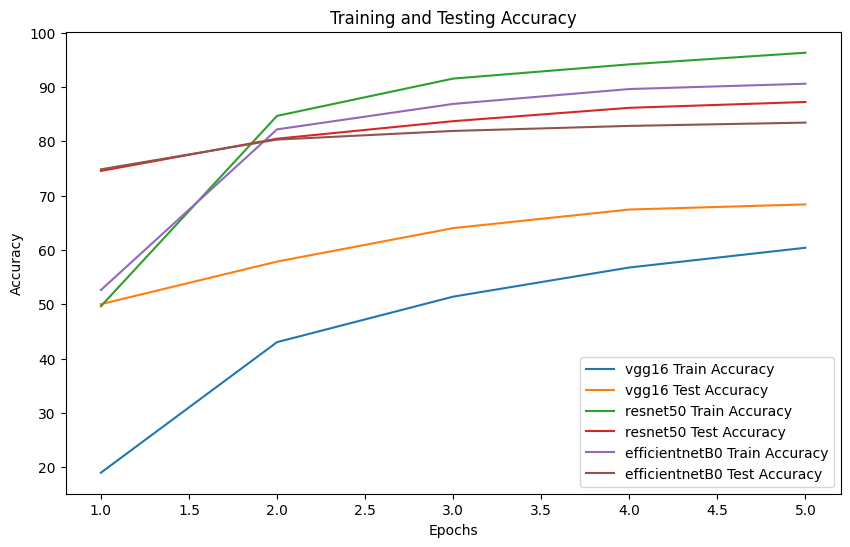

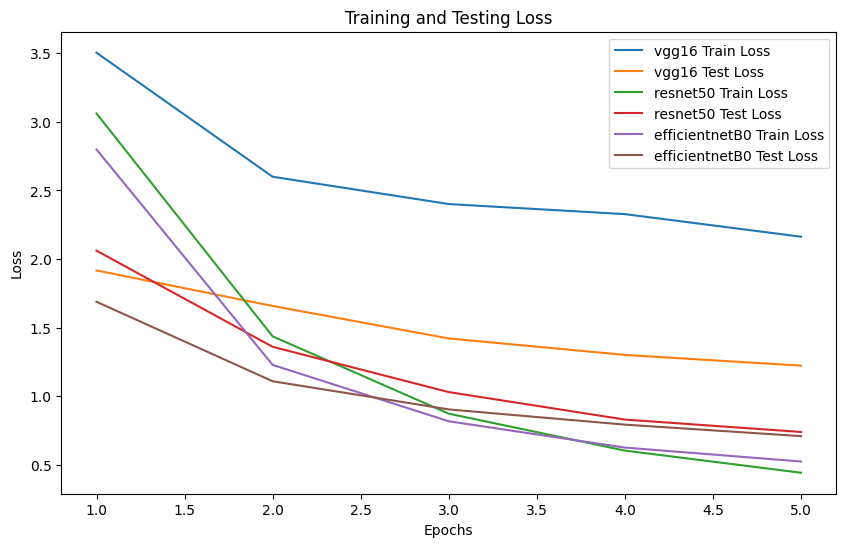

In [29]:
# Number of epochs
epochs = range(1, EPOCHS + 1)

# Plotting accuracy
plt.figure(figsize=(10, 6))
for model_name in model_names:
    plt.plot(epochs, result[f"{model_name}_train_accuracy"], label=f"{model_name} Train Accuracy")
    plt.plot(epochs, result[f"{model_name}_test_accuracy"], label=f"{model_name} Test Accuracy")

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.figure(figsize=(10, 6))
for model_name in model_names:
    plt.plot(epochs, result[f"{model_name}_train_loss"], label=f"{model_name} Train Loss")
    plt.plot(epochs, result[f"{model_name}_test_loss"], label=f"{model_name} Test Loss")

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
MODEL_PATH = Path('../artifacts/models/')
MODEL_PATH.mkdir(exist_ok=True)
torch.save(model_vgg16.state_dict(), os.path.join(MODEL_PATH,'vgg16.pth'))
torch.save(model_resnet50.state_dict(), os.path.join(MODEL_PATH, 'resnet50.pth'))
torch.save(model_efficientnetB0.state_dict(), os.path.join(MODEL_PATH, 'efficientnetB0.pth'))

In [10]:
MODEL_PATH = Path('../artifacts/models/')
device = 'cpu'
model_resnet50_weights = models.ResNet50_Weights.DEFAULT
model_resnet50 = models.resnet50(weights=model_resnet50_weights).to(device)
# Changing the layer of resnet50 model
model_resnet50.fc = nn.Linear(in_features=2048, out_features=len(class_names)).to(device)
model_resnet50.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'resnet50.pth')))

<All keys matched successfully>

In [ ]:
del model_vgg16
del model_resnet50
del model_efficientnetB0

In [ ]:
torch.cuda.empty_cache()

In [11]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [33]:
from typing import List
def predict(model: nn.Module, 
            image: Image, 
            transform: transforms.Compose, 
            device: torch.device, 
            class_names: List[str]) -> tuple:
    """
    Predict the class label, probability, and class name for the input image.

    Parameters:
    - model (nn.Module): The trained PyTorch model.
    - image (Image): The PIL Image to be predicted.
    - transform (transforms.Compose): Transformation applied to the input image.
    - device (torch.device): Device (CPU or GPU) to perform the prediction.
    - class_names (List[str]): List of class names corresponding to the model's output.

    Returns:
    - Tuple[str, float, str]: A tuple containing the predicted label, probability, and class name.
    """
    
    # Set the model for evaluation phase
    model.eval()

    model.to(device)

    with torch.inference_mode():
        # Transform the image to tensors    
        transformed_image = transform(image)

        # Add an extra dimension to the tensor image so that it matches the model input size
        transformed_image = transformed_image.unsqueeze(dim=0).to(device)

        # Predict on the image
        prediction = model(transformed_image)

    # Converting the prediction to prediction probability
    prediction_prob = torch.softmax(prediction, dim=1)

    # Getting the highest index value from the prediction probability 
    prediction_label = torch.argmax(prediction_prob, dim=1)
    
    # Get the corresponding class name
    prediction_class = class_names[prediction_label]

    # Get the probalility/confidence value associated with the predicted label
    prediction_confidence = prediction_prob[0, prediction_label]

    return prediction_label.item(), prediction_confidence.item(), prediction_class

image = Image.open('../artifacts/data_ingestion/butterfly-image-classification/test/Image_2.jpg')
predict(model_resnet50, image, transform, device, class_names)                                           

(24, 0.7079113721847534, 'CRIMSON PATCH')